downloading necessary modules

In [94]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

reading features + ground truth 

In [86]:
features_df = pd.read_csv('ctd_hypertension_20240223_scores.tsv', sep='\t')
ground_truth_df = pd.read_csv('merged_hyperhyper.tsv', sep='\t')

print(features_df)
print(ground_truth_df)

           drugA    drugB     sAB  opAB  meanspAB  medianspAB  minspAB  \
0        DB06709  DB08506  0.3427     0    0.6150       0.630     0.46   
1        DB06709  DB02376  0.4188     0    0.6850       0.685     0.56   
2        DB06709  DB04282  0.4188     0    0.6850       0.685     0.56   
3        DB06709  DB04564  0.4188     0    0.6850       0.685     0.56   
4        DB06709  DB04659  0.4188     0    0.6850       0.685     0.56   
...          ...      ...     ...   ...       ...         ...      ...   
9730661  DB08873  DB07191  0.1295     0    0.6093       0.625     0.44   
9730662  DB08873  DB08846  0.1319     0    0.4865       0.460     0.20   
9730663  DB08873  DB08865  0.1585     0    0.4858       0.480     0.26   
9730664  DB08873  DB05891  0.1004     0    0.8725       0.870     0.65   
9730665  DB08873  DB05508  0.2084     0    0.5350       0.530     0.41   

         maxspAB    zTDA    zTDB  ...  opAD  opBD  meanspAD  meanspBD  \
0           0.74  0.5076  1.2273  ... 

merge features, ground truth over drugA drugB 

In [87]:
merged_df = pd.merge(features_df, ground_truth_df, on=['drugA', 'drugB'])
merged_df.set_index(['drugA', 'drugB'], inplace=True)
print(merged_df)

                    sAB  opAB  meanspAB  medianspAB  minspAB  maxspAB    zTDA  \
drugA   drugB                                                                   
DB00001 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB00006 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB00278 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB06695 DB08932  0.2533     0    0.4450       0.445     0.38     0.51 -1.0344   
DB00393 DB01116  0.6340     0    0.7717       0.775     0.58     0.95 -2.3273   
...                 ...   ...       ...         ...      ...      ...     ...   
DB08899 DB08932  0.1233     0    0.3000       0.300     0.28     0.32 -1.1392   
DB08905 DB08932  0.3833     0    0.5550       0.555     0.55     0.56  0.2616   
DB08918 DB08932  0.1547     0    0.5200       0.520     0.41     0.61 -2.0288   
DB08932 DB08953  0.3467     0    0.5200       0.520     0.51     0.53 -0.3467   
        DB08954  0.0550     

X and Y for training and testing

In [88]:
X = merged_df.drop(['adv/app','drugcomb','sA','sB','opA','opB'], axis=1)
# Annahme: 'adv/app' ist Ihre Zielvariable
Y = merged_df['adv/app']

print(Y)

drugA    drugB  
DB00001  DB01626    1
DB00006  DB01626    1
DB00278  DB01626    1
DB06695  DB08932    1
DB00393  DB01116    1
                   ..
DB08899  DB08932    1
DB08905  DB08932    1
DB08918  DB08932    1
DB08932  DB08953    1
         DB08954    1
Name: adv/app, Length: 6935, dtype: int64


split of train and test groups, decisiontreeclassifier, look at feature importances + calculate cumulative sum of features + plot L50

In [89]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

In [114]:
# Step 1: Define the search space for Bayesian Optimization
search_spaces = {
    'max_depth': (1, 20),
    'min_samples_leaf': (1, 20),
    'min_samples_split': (2, 20),
    'class_weight': ['balanced', None]
}

# Step 2: Define a custom scorer for accuracy to use with BayesSearchCV
accuracy_scorer = make_scorer(accuracy_score)

# Step 3: Initialize the Oversampler
oversampler = SMOTE()

# Step 4: Apply Oversampling
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train, Y_train)

# Step 5: Recursive Feature Elimination
dt_classifier = DecisionTreeClassifier(random_state=42)
rfe = RFE(estimator=dt_classifier, n_features_to_select=10, step=1)
X_train_resampled_rfe = rfe.fit_transform(X_train_resampled, Y_train_resampled)
X_test_rfe = rfe.transform(X_test)

# Step 6: Bayesian Optimization
opt = BayesSearchCV(
    estimator=DecisionTreeClassifier(),
    search_spaces=search_spaces,
    n_iter=10,
    scoring=accuracy_scorer,
    cv=5
)
opt.fit(X_train_resampled_rfe, Y_train_resampled)

# Step 7: Fine-tuning with Grid Search around the best parameters from Bayesian Optimization
param_grid = {
    'max_depth': [opt.best_params_['max_depth'] - 1, opt.best_params_['max_depth'], opt.best_params_['max_depth'] + 1],
    'min_samples_leaf': [opt.best_params_['min_samples_leaf'] - 1, opt.best_params_['min_samples_leaf'], opt.best_params_['min_samples_leaf'] + 1],
    'min_samples_split': [opt.best_params_['min_samples_split'] - 1, opt.best_params_['min_samples_split'], opt.best_params_['min_samples_split'] + 1],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    scoring=accuracy_scorer,
    cv=5
)
grid_search.fit(X_train_resampled_rfe, Y_train_resampled)

# Step 8: Get the best model
clf = grid_search.best_estimator_



# Zeigen Sie die besten gefundenen Hyperparameter an
print("Beste Hyperparameter:", opt.best_params_)
predictions = clf.predict(X_test_rfe)
report = classification_report(Y_test, predictions)
print(report)

AttributeError: 'BaggingClassifier' object has no attribute 'transform'

In [101]:
comparison = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions})
#print(comparison.head(20))
#specific_drug_combination = ('DB01599', 'DB04825')
# Create a boolean mask where 'Actual' and 'Predicted' values are not equal
mask = comparison['Actual'] != comparison['Predicted']

# Apply this mask to your DataFrame to filter rows
differences = comparison[mask]

#28 falsch predicted
print(differences)
print(len(differences))

print("Accuracy:", accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions, labels=[0,1]))

                 Actual  Predicted
drugA   drugB                     
DB00661 DB00433       1          0
DB00060 DB00108       0          1
DB00575 DB06288       1          0
DB00381 DB01076       0          1
DB00784 DB00968       1          0
DB00457 DB01240       1          0
DB00321 DB00524       1          0
DB00559 DB00562       1          0
DB00217 DB06684       1          0
DB00350 DB00443       0          1
DB00880 DB00968       0          1
DB00968 DB04838       1          0
DB00630 DB00860       0          1
DB00575 DB06684       1          0
DB00843 DB00524       1          0
DB00533 DB00580       0          1
DB00559 DB00999       1          0
DB00328 DB00524       1          0
DB00590 DB00860       1          0
DB00559 DB00706       1          0
DB01119 DB07118       1          0
DB00328 DB00433       1          0
DB00203 DB00440       0          1
DB00381 DB00524       1          0
DB01018 DB06288       1          0
DB00381 DB00433       1          0
DB00217 DB00247     

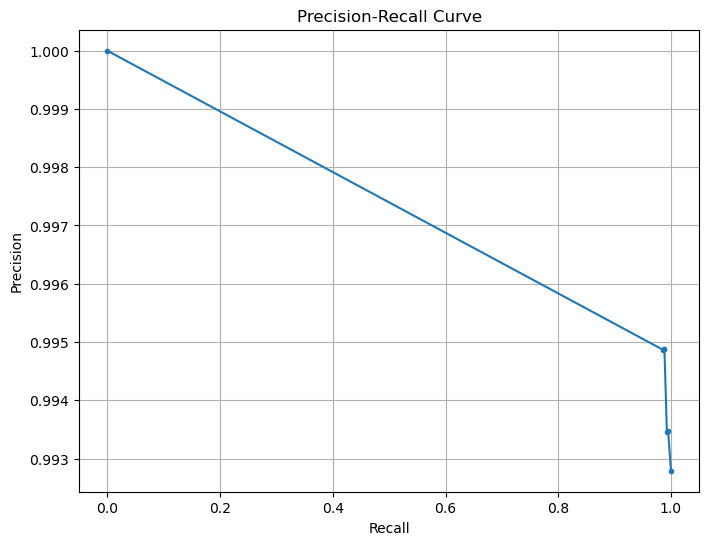

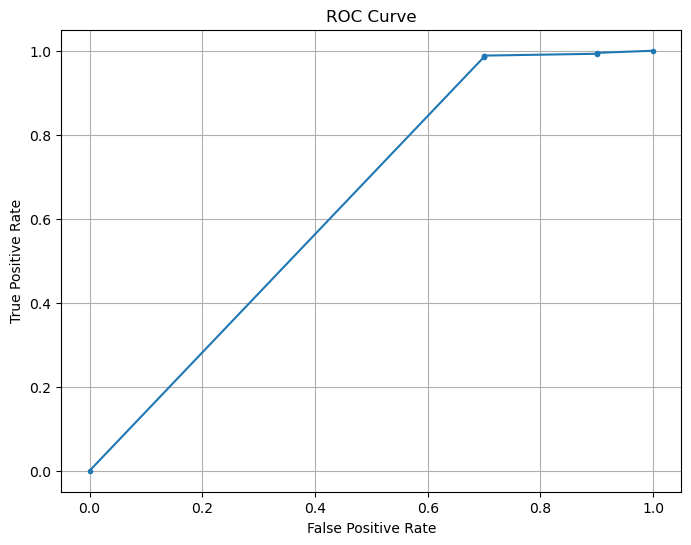

ROC AUC: 0.6427741466957153
Matthews Correlation Coefficient: 0.18913198059410538
Weighted F1 Score: 0.9843216684146179


In [104]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, matthews_corrcoef, f1_score

# Assuming 'clf' is your trained classifier
y_pred_probs = clf.predict_proba(X_test_rfe)[:, 1]  # Predict probabilities for positive class

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(Y_test, y_pred_probs)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_probs)

# Calculate ROC AUC score
roc_auc = roc_auc_score(Y_test, y_pred_probs)

# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(Y_test, clf.predict(X_test_rfe))

# Calculate weighted F1 score
weighted_f1 = f1_score(Y_test, clf.predict(X_test_rfe), average='weighted')

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# Print ROC AUC score
print(f'ROC AUC: {roc_auc}')

# Print Matthews correlation coefficient
print(f'Matthews Correlation Coefficient: {mcc}')

# Print weighted F1 score
print(f'Weighted F1 Score: {weighted_f1}')


In [ ]:
'''
ROC AUC: 0.6427741466957153
Matthews Correlation Coefficient: 0.18913198059410538
Weighted F1 Score: 0.9843216684146179
'''

In [93]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

cumulative_importances = np.cumsum(importances[indices])

num_features_50 = np.where(cumulative_importances >= 1)[0][0] + 1

plt.figure()
plt.title("Feature Importances")
plt.bar(range(num_features_50), importances[indices][:num_features_50], color='yellow')
plt.xticks(range(num_features_50), X.columns[indices][:num_features_50], rotation=90)
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0